In [1]:
import numpy as np
import torch
from torch import nn
import time
import matplotlib.pyplot as plt

MG_data = np.load('E:/ukf_data/Mackey_Glass/mgts_len=5000000tau=18n=10.0bet=0.25gam=0.1h=0.9T=1.npy', allow_pickle=True)
print(type(MG_data))
print(MG_data.shape)

<class 'numpy.ndarray'>
(5000000,)


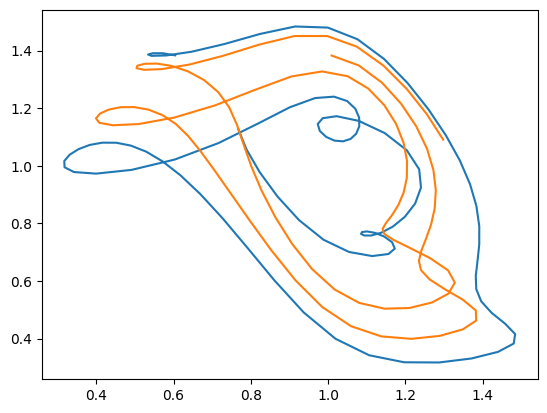

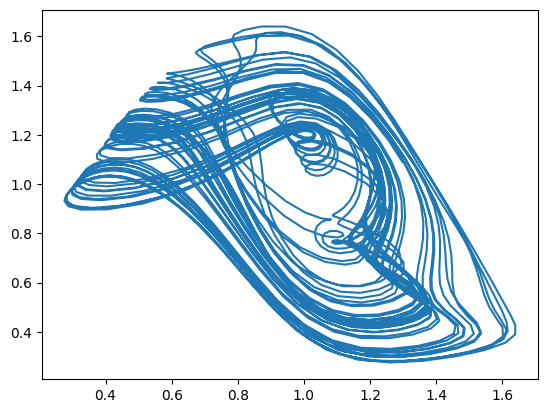

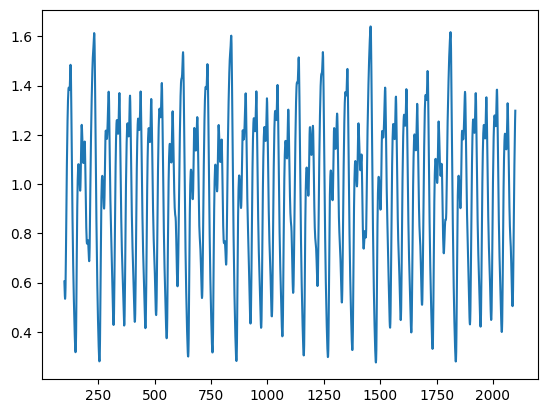

In [24]:
tau = 18
sample_start = 100
sample_len = 100
plt.plot(MG_data[sample_start:sample_start+sample_len], MG_data[sample_start + tau : sample_start+sample_len + tau])
sample_start = 2000
plt.plot(MG_data[sample_start:sample_start+sample_len], MG_data[sample_start + tau : sample_start+sample_len + tau])
plt.show()

sample_start = 100
sample_len = 2000
plt.plot(MG_data[sample_start:sample_start+sample_len], MG_data[sample_start + tau : sample_start+sample_len + tau])
plt.show()

plt.plot(range(sample_start, sample_start + sample_len), MG_data[sample_start:sample_start+sample_len])
plt.show()

In [25]:
from torch.utils.data import Dataset, DataLoader

class MacKey_Glass(Dataset):
    def __init__(self, data_path, 
                 data_len = 100000, 
                 start_point = 100000,
                 input_len = 6,
                 input_transform=None, 
                 target_transform=None
                 ):
        super(MacKey_Glass, self).__init__()
        self.data = np.load(data_path, allow_pickle= True).astype(np.float32)
        self.all_data_len = len(self.data)
        self.input_len = input_len
        self.data_len = data_len
        self.start_point = start_point

        self.input_transform = input_transform
        self.target_transform = target_transform

    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        return self.data[idx : idx + self.input_len], self.data[idx + self.input_len]
    
data_path = 'E:/ukf_data/Mackey_Glass/mgts_len=5000000tau=18n=10.0bet=0.25gam=0.1h=0.9T=1.npy'

train_start = 100
train_len = 100
test_start = train_start + train_len
test_len = 10000

train_data = MacKey_Glass(data_path=data_path, data_len=train_len, start_point=train_start, input_len=6)
test_data = MacKey_Glass(data_path=data_path, data_len=test_len, start_point=test_start, input_len=6)

train_loader = DataLoader(train_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [26]:
def get_f(name: str = "tanh") -> nn.Module:
    activations = nn.ModuleDict(
        [
            ["lrelu", nn.LeakyReLU(0.1)],
            ["relu", nn.ReLU()],
            ["tanh", nn.Tanh()],
        ]
    )
    return activations[name]

def dense_block(layers : list(), activation: str) -> nn.Sequential:
    out = list()
    for idx, (in_f, out_f) in enumerate(zip(layers, layers[1:])):
        if idx == len(layers) - 2:
            out.append(nn.Linear(in_f, out_f, bias=False))
        else:
            out.append(nn.Linear(in_f, out_f))
            if activation is not None:
                out.append(get_f(activation))
    return nn.Sequential(*out)

class neural_network(nn.Module):
    def __init__(
            self,
            input_dim = 1025, 
            hidden_dim = 1000, 
            output_dim = 1025, 
            n_layers = 8,
            activation = 'relu' 
            ):
        super(neural_network, self).__init__()
        self.layers = [input_dim] + [hidden_dim] * n_layers + [output_dim]
        self.net = dense_block(self.layers, activation)

    def forward(self, x):
        
        return self.net(x)
    

In [36]:
model = neural_network(input_dim=6, hidden_dim=6, output_dim=1, n_layers=1, activation='tanh')
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.001)
loss = torch.nn.functional.mse_loss
epochs = 5000

loss_history = [[], [], []]

start_time = time.time()
for _ in range(epochs):
    model.train()
    l1 = 0
    for inp, tar in train_loader:
        tar = torch.unsqueeze(tar, dim=1)
        optimizer.zero_grad()
        output = model(inp)
        l = loss(output, tar)
        l.backward()
        optimizer.step()
        l1 += l.item()

    if (_ % 500 == 0) or (_+1 == epochs):
        model.eval()
        loss_history[1].append(l1) # now : loss of final batch, todo
        loss_history[0].append(_)
        print(f'epoch num {_} loss :', end=' ')
        print(l1, end=' ')
        l2=0
        for idx, (inp, tar) in enumerate(test_loader):
            tar = torch.unsqueeze(tar, dim=1)
            output = model(inp)
            l = loss(output, tar)
            l2 += l.item()
        l2 /= (idx+1)
        loss_history[2].append(l2)
        print(l2)

print(f'time : {time.time() - start_time : .2f}')

epoch num 0 loss : 0.8817366361618042 0.4355240328402459
epoch num 500 loss : 0.01523582823574543 0.008702128400578152
epoch num 1000 loss : 0.0037011662498116493 0.0018706325975046316
epoch num 1500 loss : 0.0028146912809461355 0.0014072405719610897
epoch num 2000 loss : 0.0021152825211174786 0.0010495871700393626
epoch num 2500 loss : 0.0014739908510819077 0.0007270353004819702
epoch num 3000 loss : 0.000964752834988758 0.0004735106758513971
epoch num 3500 loss : 0.0006484290061052889 0.0003200501761299004
epoch num 4000 loss : 0.000498084002174437 0.0002515462884396503
epoch num 4500 loss : 0.0004364875057945028 0.00022627083515406503
epoch num 4999 loss : 0.00040595517202746123 0.00021415781778654768
time :  9.27


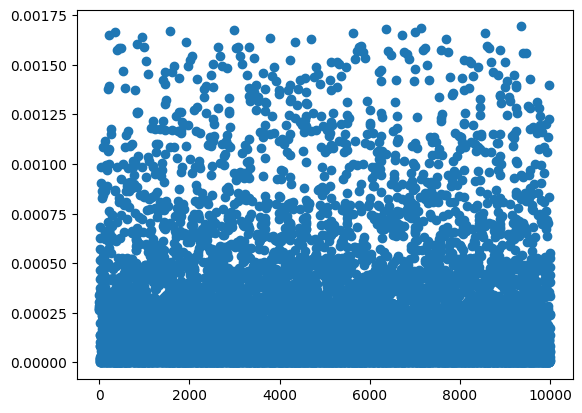

In [37]:
# test_data = MacKey_Glass(data_path=data_path, data_len=100000, start_point=2000, input_len=6)
# test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

model.eval()
test_loss_history = []
target_list = []
output_list = []

for inp, tar in test_loader:
    target_list.extend(tar.tolist())
    tar = torch.unsqueeze(tar, dim=1)
    output = model(inp)
    output_list.extend([_[0] for _ in output.tolist()])
    # test_loss_history.append(loss(output, tar).item())
    test_loss_history.extend(loss(output, tar, reduce=False).tolist())

test_loss_history = [i[0] for i in test_loss_history]

plt.scatter(range(len(test_loss_history)), test_loss_history)
# plt.ylim(0, 0.01)
plt.show()

In [38]:
print(len(test_loss_history))
# print(sum(test_loss_history[:20]) * 100)
# print(sum(test_loss_history[:200]) * 10)
print(sum(test_loss_history[:2000]))
print(sum(test_loss_history[2000:4000]))
print(sum(test_loss_history[4000:6000]))
print(sum(test_loss_history[6000:8000]))
print(sum(test_loss_history[8000:]))

10000
0.43105296531701853
0.42976390827893596
0.4226970398814247
0.42631094762968846
0.42929636594995735


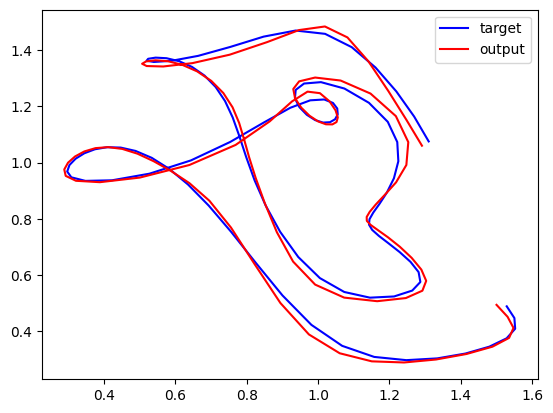

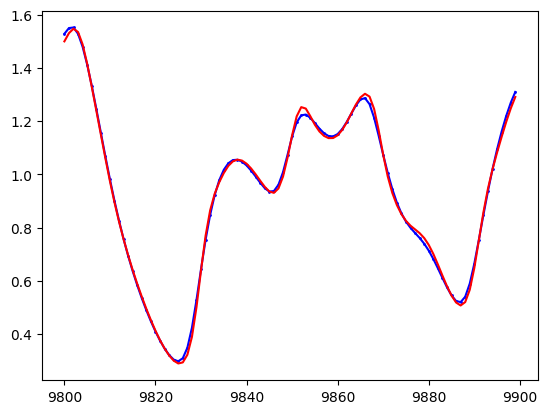

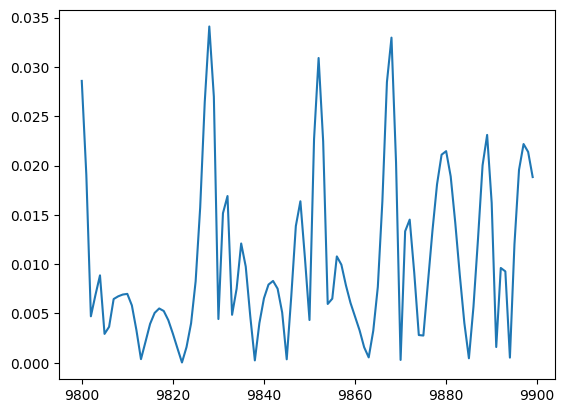

In [39]:
# test data
tau = 18
s = 9800
e = 100

plt.plot(target_list[s:s+e], target_list[s+tau:s+e+tau], c = 'b', label='target')
plt.plot(output_list[s:s+e], output_list[s+tau:s+e+tau], c = 'r', label='output')
plt.legend()
plt.show()

# plt.scatter(target_list[s:s+e], target_list[s+tau:s+e+tau], c = 'b', label='target')
# plt.scatter(output_list[s:s+e], output_list[s+tau:s+e+tau], c = 'r', label='output')
# plt.legend()
# plt.show()

plt.plot(range(s, s+e), target_list[s : s+e], c = 'b')
plt.scatter(range(s, s+e), target_list[s : s+e], c = 'b', s = 1)
plt.plot(range(s, s+e), output_list[s : s+e], c = 'r')
plt.show()

plt.plot(range(s, s+e), [np.abs(i-j) for i,j in zip(target_list[s : s+e], output_list[s : s+e])])
plt.show()

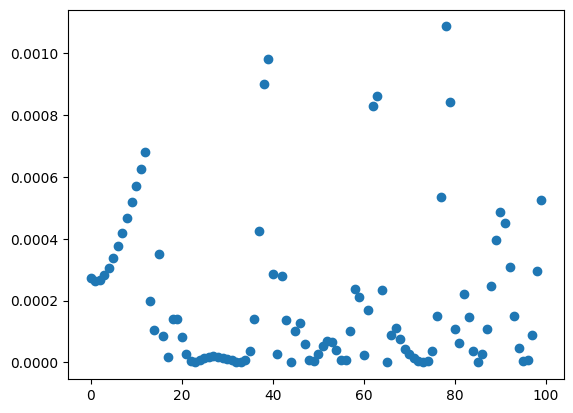

In [40]:
# train data

model.eval()
test_loss_history = []
target_list = []
output_list = []

# train_data = MacKey_Glass(data_path=data_path, data_len=200, start_point=200, input_len=6)
# train_loader = DataLoader(train_data, batch_size=128, shuffle=False)

for inp, tar in train_loader:
    target_list.extend(tar.tolist())
    tar = torch.unsqueeze(tar, dim=1)
    output = model(inp)
    output_list.extend([_[0] for _ in output.tolist()])
    # test_loss_history.append(loss(output, tar).item())
    test_loss_history.extend(loss(output, tar, reduce=False).tolist())

test_loss_history = [i[0] for i in test_loss_history]

plt.scatter(range(len(test_loss_history)), test_loss_history)
# plt.ylim(0, 0.01)
plt.show()

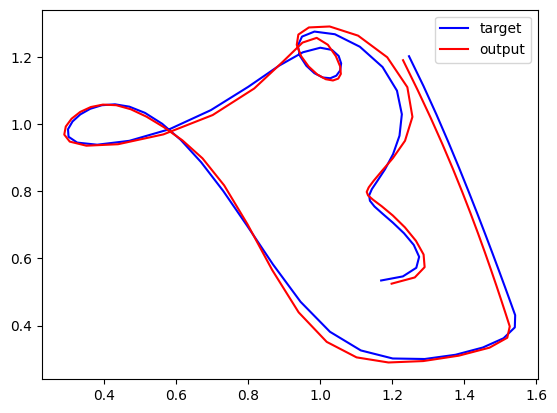

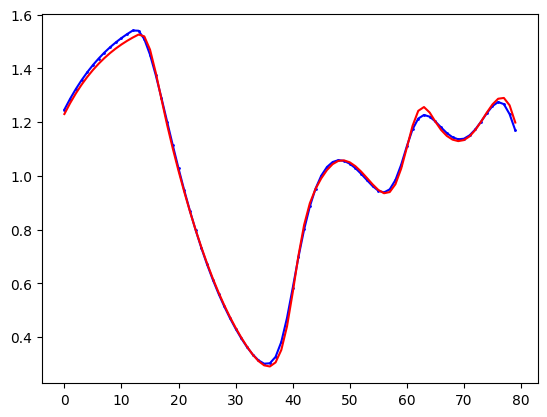

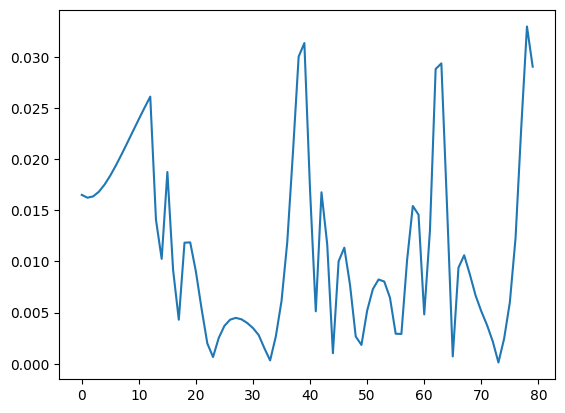

In [41]:
# train data

tau = 18
s = 0
e = 80

plt.plot(target_list[s:s+e], target_list[s+tau:s+e+tau], c = 'b', label='target')
plt.plot(output_list[s:s+e], output_list[s+tau:s+e+tau], c = 'r', label='output')
plt.legend()
plt.show()

# plt.scatter(target_list[s:s+e], target_list[s+tau:s+e+tau], c = 'b', label='target')
# plt.scatter(output_list[s:s+e], output_list[s+tau:s+e+tau], c = 'r', label='output')
# plt.legend()
# plt.show()

plt.plot(range(s, s+e), target_list[s : s+e], c = 'b')
plt.scatter(range(s, s+e), target_list[s : s+e], c = 'b', s = 1)
plt.plot(range(s, s+e), output_list[s : s+e], c = 'r')
plt.show()

plt.plot(range(s, s+e), [np.abs(i-j) for i,j in zip(target_list[s : s+e], output_list[s : s+e])])
plt.show()